# Sentiment Analysis and Evaluative Language

### Implementation for English Dataset

In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.similarities import Similarity

import numpy as np
import pandas as pd
from scipy import spatial

import csv
import io
import glob
import spacy
import re
import string
import random
from random import sample
from itertools import chain
import pickle

from spacy.lang.en import English
import nltk

from collections import Counter
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation

from textblob import TextBlob
from itertools import cycle

C:\Users\Brottrager\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def tokenize_pipe(doc):
    tok_list = [tok.text.lower() for tok in doc
                  if tok.is_alpha] 
    return tok_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=8):
        preproc_pipe.append(tokenize_pipe(doc))
    return preproc_pipe

In [3]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 1000000000

#### Reviews: Data import and preprocessing

In [4]:
reviews_eng = r"C:\Users\Brottrager\Documents\Diss\reviews\ENG_reviews"
additional_text = r"C:\Users\Brottrager\Documents\Diss\corpora\eng\3_corpus_txt_from_updatedXML"

In [5]:
list_files = glob.glob(reviews_eng + '/*.txt')
list_additional = glob.glob(additional_text + '/*.txt')

In [6]:
reviews_txt = []
for file_path in list_files:
    with open(file_path, encoding="utf-8") as file:
        reviews_txt.append(file.read())
        
additional_txt = []
for file_path in list_additional:
    with open(file_path, encoding="utf-8") as file:
        additional_txt.append(file.read())

In [7]:
reviews_txt_clean = [word.replace('\n',' ') for word in reviews_txt]
reviews_txt_clean = [word.lower() for word in reviews_txt_clean]

#reviews = preprocess_pipe(reviews_txt_clean)

#with open(r'C:\...\ENG_reviews_tok.pkl', 'wb') as f:
#    pickle.dump(reviews, f)

In [8]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\ENG_reviews_tok.pkl', 'rb') as f:
    reviews = pickle.load(f)

In [9]:
reviews_toks = [tok for sent in reviews for tok in sent]

In [10]:
df_fdist_reviews = pd.DataFrame(reviews_toks, columns=['Freq'])
relfreq_reviews = pd.DataFrame(df_fdist_reviews['Freq'].value_counts())
relfreq_reviews = relfreq_reviews / len(reviews_toks)

#### Comparative corpus: Data import and preprocessing

In [11]:
#additional_txt_clean = [word.replace('\n',' ') for word in additional_txt]
#additional_txt_clean = [word.lower() for word in additional_txt_clean]

#additional = preprocess_pipe(additional_txt_clean)

#with open(r'C:\...\ENG_additional_lemma.pkl', 'wb') as f:
#    pickle.dump(additional, f)

In [12]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\GER_additional_tok.pkl', 'rb') as f:
    additional = pickle.load(f)

In [13]:
additional_toks = [tok for sent in additional for tok in sent if tok.isalpha()]

In [14]:
df_fdist_additional = pd.DataFrame(additional_toks, columns=['Freq'])
relfreq_additional = pd.DataFrame(df_fdist_additional['Freq'].value_counts())
relfreq_additional = relfreq_additional / len(additional_toks)

#### Comparative frequency

In [15]:
in_novels = []
in_reviews = []
for row in relfreq_reviews.index:
    freq_reviews = float(relfreq_reviews.loc[row])
    freq_additional = 0
    if row in relfreq_additional.index:
        freq_additional = float(relfreq_additional.loc[row])
    score = freq_reviews-freq_additional
    if score > 0:
        #print(row + ": " + str(freq_reviews) + " | " + str(freq_additional)) 
        in_reviews.append([row, score])
    else:
        in_novels.append([row, score])

In [16]:
len(in_reviews)

13049

In [17]:
in_reviews_words = []
for entry in in_reviews:
    in_reviews_words.append(entry[0])

#### Word embedding

In [18]:
#all_toks = additional_toks + reviews_toks
#sents = additional + reviews
#model = Word2Vec(sentences = sents, vector_size=300, window=5, min_count=5, workers=4)

#with open(r'C:\...\ENG_reviews_model_FINAL.pkl', 'wb') as f:
#    pickle.dump(model, f)

In [19]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\pickled\ENG_reviews_model_FINAL.pkl', 'rb') as f:
    model = pickle.load(f)

#### Evaluative words

In [20]:
pos = ["ADJ","NOUN"]
reviews_pos = []
for doc in nlp.pipe(reviews_txt_clean, disable=["ner"]):
    sentence_toks = [[token.text for token in sent if token.pos_ in pos] for sent in doc.sents]
    reviews_pos = reviews_pos + sentence_toks

In [21]:
stopwords = nltk.corpus.stopwords.words("english")

In [22]:
reviews_tok_clean = [[tok for tok in review if tok not in stopwords] for review in reviews_pos]

In [23]:
reviews_toks = []
for review in reviews_tok_clean:
    for tok in review:
        if tok in in_reviews_words:
            reviews_toks.append(tok)

In [24]:
reviews_tok_clean_top = Counter(reviews_toks).most_common(10000)
corpus_top = [i[0] for i in reviews_tok_clean_top]

In [25]:
pos = ["excellent","admirable","estimable","exemplary",
       "invaluable","incomparable","superb","outstanding",
       "wonderful","perfect","superior","worthy","fine",
       "exceptional","skillful","masterful","extraordinary",
       "impressive","notable","noteworthy"]

In [26]:
len(pos)

20

In [27]:
add_pos = []
for p in pos:
    x = model.wv.most_similar(p, topn=2)
    for entry in x:
        add_pos.append(entry[0])

In [28]:
neg = ["terrible","grievous","hideous","ghastly",
       "disgusting","unfavourable","disagreeable","distasteful",
       "error","fault","unpleasant","imprudent","unlikely",
       "undesirable","unreasonable","absurd","offensive",
       "unsuitable","questionable","disconcerting"]

In [29]:
len(neg)

20

In [30]:
add_neg = []
for p in neg:
    x = model.wv.most_similar(p, topn=2)
    for entry in x:
        add_neg.append(entry[0])

In [31]:
val_words = pos + neg + add_pos + add_neg
val_words = list(set(val_words))

In [32]:
remaining_words = []
for word in val_words:
    if word in corpus_top:
        remaining_words.append(word)
    #else:
    #    print(word)

In [33]:
len(remaining_words)

78

#### Review analysis / SentiArt

In [34]:
l = []
for word in remaining_words:
    l.append(model.wv[word])
X = np.array(l)

In [35]:
af = AffinityPropagation(random_state=1).fit(X)

In [36]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

In [37]:
n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 17


In [38]:
cluster_words = [""]*len(cluster_centers_indices)
i = 0

for label in labels:
    cluster_num = int(label)
    cluster_words[cluster_num] = cluster_words[cluster_num] + " " + remaining_words[i]
    i += 1

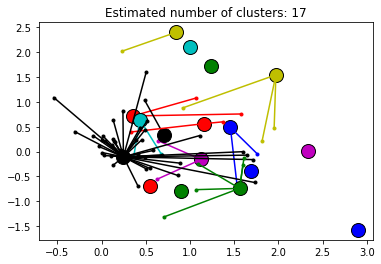

In [39]:
plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
        )
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [40]:
cluster_words

[' absurd ridiculous unreasonable',
 ' nice',
 ' worthy deserving unworthy',
 ' amiable admirable excellent',
 ' marvellous astonishing startling wonderful',
 ' superior inferior',
 ' perfect complete',
 ' fault',
 ' blame',
 ' superb magnificent splendid',
 ' superiority',
 ' fine',
 ' remarkable unusual singular extraordinary',
 ' impressive exemplary disgusting offensive distressing estimable ludicrous inestimable pathetic disagreeable distasteful emphatic advantageous noteworthy notable inimitable imprudent questionable incomparable favorable unfavourable indiscretion consummate unexceptionable improbable improper unlimited abnormal repulsive embarrassing unlikely energetic undesirable grievous unsuitable defiant exceptional overdue desirable unpleasant outstanding',
 ' handsome',
 ' terrible horrible hideous ghastly frightful dreadful',
 ' error']

In [41]:
#Check indeces and adapt if necessary
pos_centroids = [X[cluster_centers_indices[15]],X[cluster_centers_indices[7]],X[cluster_centers_indices[2]]]

' extraordinary unusual remarkable singular',
' startling marvellous wonderful astonishing'
' admirable excellent amiable'

In [42]:
#Check indeces and adapt if necessary
neg_centroids = [X[cluster_centers_indices[11]]]

' ghastly horrible hideous terrible'

In [43]:
vocab = model.wv.key_to_index

In [44]:
keys = []
similarity = []
all_pos = []
all_neg = []
for word in corpus_top:
    if word in vocab.keys():
        vec = model.wv[word]

        pos = 0
        for centroid in pos_centroids:
            pos = np.dot(centroid, vec)/(np.linalg.norm(centroid)* np.linalg.norm(vec))
            all_pos.append(pos)
        pos = pos/len(pos_centroids)

        neg = 0
        for centroid in neg_centroids:
            neg = np.dot(centroid, vec)/(np.linalg.norm(centroid)* np.linalg.norm(vec))
            all_neg.append(neg)
        neg = neg/len(neg_centroids)

        sim = pos-neg
        similarity.append(sim)
        keys.append(word)

In [45]:
senti_dict = dict(zip(keys,similarity))

In [46]:
senti_dict

{'mr': 0.040844540422161416,
 'story': 0.043140656004349395,
 'life': 0.07993910213311513,
 'author': 0.1313945862154166,
 'book': -0.022986081118384995,
 'good': -0.35908716917037964,
 'little': -0.17533131618984044,
 'old': -0.1354481801390648,
 'great': -0.21463546653588614,
 'work': -0.08506236846248308,
 'character': 0.05686522896091144,
 'time': 0.054030766089757286,
 'young': -0.225399191180865,
 'reader': 0.08859558527668317,
 'many': -0.08091320097446442,
 'first': -0.01714908704161644,
 'novel': -0.1538072501619657,
 'lady': 0.05532805000742276,
 'much': -0.0359260489543279,
 'part': 0.10560420403877893,
 'mind': 0.02252611145377159,
 'love': 0.08460178785026073,
 'mrs': 0.05692054703831673,
 'interest': 0.08593806624412537,
 'way': 0.024908716479937233,
 'nature': 0.07723912472526231,
 'father': 0.10393939058606823,
 'woman': 0.03261747770011425,
 'tale': 0.05177683134873708,
 'whole': -0.05752865908046564,
 'present': 0.1187080591917038,
 'heart': 0.08275021240115166,
 'wor

In [47]:
reviews_toks = []
for doc in nlp.pipe(reviews_txt_clean, disable=["ner"]):
    sentence_toks = [[token.text for token in sent if token.text not in stopwords and token.is_alpha] for sent in doc.sents]
    reviews_toks.append(sentence_toks)

In [48]:
reviews_sentiscores = []
for review in reviews_toks:
    sentiscores_review_level = []
    sentence_count = 0
    
    for sentence in review:
        sentiscores_sent_level = []
        
        for word in sentence:
            if word in senti_dict.keys():
                score = senti_dict[word]
                sentiscores_sent_level.append(score)
                
        if len(sentiscores_sent_level) != 0:
            sentiscores_review_level.append(sum(sentiscores_sent_level)/len(sentiscores_sent_level))
        else:
            sentiscores_review_level.append(0)
    
    if len(sentiscores_review_level) != 0:
        reviews_sentiscores.append(sum(sentiscores_review_level)/len(sentiscores_review_level))
    else:
        reviews_sentiscores.append(0)

#### Comparison: Sentiment analysis with TextBlob

In [49]:
all_sentiment_scores = []
for review in reviews_toks:
    sentiscores_review_level = []
    sentence_count = 0
    
    for sentence in review:
        sentiscores_sent_level = []
        
        for word in sentence:
            score = TextBlob(word).sentiment.polarity
            if word in senti_dict.keys():
                score = score * 1.5
            sentiscores_sent_level.append(score)
                
        if len(sentence) != 0:
            sentiscores_review_level.append(sum(sentiscores_sent_level)/len(sentence))
        else:
            sentiscores_review_level.append(0)
        
    if len(review) != 0:
        all_sentiment_scores.append(sum(sentiscores_review_level)/len(review))
    else:
        all_sentiment_scores.append(0)

In [50]:
filenames = []
journals = []
text_ids = []
for file in list_files:
    filename = re.sub(r".+reviews\\(.+).txt", r"\1", file)
    filenames.append(filename)
    journal = re.sub(r"\d{5}_\d{4}_(.+?)_.+", r"\1", filename)
    journals.append(journal)
    text_id = re.sub(r"(\d{5})_.+", r"\1", filename)
    text_ids.append(int(text_id))

In [51]:
reviews_senti_df = pd.DataFrame(
    {'sentiscore_average': reviews_sentiscores,
     'sentiment_Textblob': all_sentiment_scores,
     'textfile': filenames,
     'journal': journals,
     'text_id': text_ids
})

In [52]:
#reviews_senti_df.to_csv(r"C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\ENG_reviews_senti_FINAL.csv",
#                        sep = ';', encoding = 'utf-8')

In [53]:
testset = pd.read_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\ENG_testset.csv', sep = ";")
reviews_senti_df = pd.read_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\ENG_reviews_senti_FINAL.csv', 
                               sep = ';', encoding = 'utf-8')

In [54]:
eval_df = pd.merge(testset, reviews_senti_df, how='inner', on=['textfile'])

In [55]:
eval_df

,textfile,class,Unnamed: 0,sentiscore_average,sentiment_Textblob,journal,text_id
0,10000_1834_ATH_323,-1,0,-0.097343,-0.028484,ATH,10000
1,10033_1900_ATH_544,-1,9,-0.032733,0.008967,ATH,10033
2,10056_1867_ATH_514,-1,25,-0.014819,0.044760,ATH,10056
3,10093_1865_ATH_844,-1,38,-0.098679,-0.030741,ATH,10093
4,10196_1805_CR_29_1,-1,79,-0.000311,0.095273,CR,10196
5,10252_1884_ATH_820,-1,105,-0.009542,0.027987,ATH,10252
6,10259_1897_ATH_743,-1,110,-0.049523,-0.005052,ATH,10259
7,10290_1792_CR_38_1,-1,122,-0.042005,-0.011842,CR,10290
8,10302_1902_ATH_346,-1,133,-0.036391,0.014729,ATH,10302
9,10396_1911_ATH_217,-1,144,-0.033083,-0.003530,ATH,10396


In [56]:
confusion_matrix_sentiscore = [[0], [0], 
                               [0], [0]]
confusion_matrix_sentiscore = pd.DataFrame(confusion_matrix_sentiscore,
                                          index = ['TP','FP','TN','FN'],
                                          columns = ['count'])
confusion_matrix_textblob = [[0], [0], 
                             [0], [0]]
confusion_matrix_textblob = pd.DataFrame(confusion_matrix_textblob,
                                          index = ['TP','FP','TN','FN'],
                                          columns = ['count'])


for index, row in eval_df.iterrows():
    sentiscore = row['sentiscore_average']
    textblob = row['sentiment_Textblob']
    classified = row['class']
    text_id = row['text_id']

    if classified == 1:
        if sentiscore > 0:
            print(str(text_id )+ ": TRUE POSITIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["TP"] += 1
        else:
            print(str(text_id )+ ": FALSE NEGATIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["FN"] += 1
            
        if textblob > 0:
            print(str(text_id )+ ": TRUE POSITIVE: " + str(classified) + " : " +  str(textblob))
            confusion_matrix_textblob.loc["TP"] += 1
        else:
            print(str(text_id )+ ": FALSE NEGATIVE: " + str(classified) + " : " +  str(textblob))
            confusion_matrix_textblob.loc["FN"] += 1
            
    else:
        if sentiscore < 0:
            print(str(text_id )+ ": TRUE NEGATIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["TN"] += 1
        else:
            print(str(text_id )+ ": FALSE POSITIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["FP"] += 1       

        if textblob < 0:
            print(str(text_id )+ ": TRUE NEGATIVE: " + str(classified) + " : " + str(textblob))
            confusion_matrix_textblob.loc["TN"] += 1
        else:
            print(str(text_id )+ ": FALSE POSITIVE: " + str(classified) + " : " + str(textblob))
            confusion_matrix_textblob.loc["FP"] += 1       


10000: TRUE NEGATIVE: -1 : -0.0973425448522686
10000: TRUE NEGATIVE: -1 : -0.0284836889301175
10033: TRUE NEGATIVE: -1 : -0.0327326508577883
10033: FALSE POSITIVE: -1 : 0.0089673871893178
10056: TRUE NEGATIVE: -1 : -0.014818980157265
10056: FALSE POSITIVE: -1 : 0.0447603435782121
10093: TRUE NEGATIVE: -1 : -0.0986794342819069
10093: TRUE NEGATIVE: -1 : -0.0307405557405557
10196: TRUE NEGATIVE: -1 : -0.0003111817719657
10196: FALSE POSITIVE: -1 : 0.0952728612421322
10252: TRUE NEGATIVE: -1 : -0.0095423061516838
10252: FALSE POSITIVE: -1 : 0.0279865244708994
10259: TRUE NEGATIVE: -1 : -0.0495234646042054
10259: TRUE NEGATIVE: -1 : -0.0050524108244696
10290: TRUE NEGATIVE: -1 : -0.0420047608825067
10290: TRUE NEGATIVE: -1 : -0.0118421052631578
10302: TRUE NEGATIVE: -1 : -0.0363910093847373
10302: FALSE POSITIVE: -1 : 0.0147291283850753
10396: TRUE NEGATIVE: -1 : -0.0330827761461333
10396: TRUE NEGATIVE: -1 : -0.0035304307960557
10472: TRUE NEGATIVE: -1 : -0.0860615194982124
10472: TRUE NE

In [57]:
confusion_matrix_sentiscore

,count
TP,9
FP,3
TN,12
FN,6


In [58]:
confusion_matrix_textblob

,count
TP,15
FP,7
TN,8
FN,0


In [59]:
tp_senti = int(confusion_matrix_sentiscore.loc["TP"])
tn_senti = int(confusion_matrix_sentiscore.loc["TN"])
fn_senti = int(confusion_matrix_sentiscore.loc["FN"])
fp_senti = int(confusion_matrix_sentiscore.loc["FP"])

recall_senti = tp_senti/(tp_senti + fn_senti)
precision_senti = tp_senti/(tp_senti + fp_senti)
accuracy_senti = (tp_senti + tn_senti) / 30

print("Sentiscore:\n" + 
      "Recall: " + str(recall_senti) + "\n" +
      "Precision: " + str(precision_senti) + "\n" +
      "Accuracy: " + str(accuracy_senti))

Sentiscore:
Recall: 0.6
Precision: 0.75
Accuracy: 0.7


In [60]:
tp_textblob = int(confusion_matrix_textblob.loc["TP"])
tn_textblob = int(confusion_matrix_textblob.loc["TN"])
fn_textblob = int(confusion_matrix_textblob.loc["FN"])
fp_textblob = int(confusion_matrix_textblob.loc["FP"])

recall_textblob = tp_textblob/(tp_textblob + fn_textblob)
precision_textblob = tp_textblob/(tp_textblob + fp_textblob)
accuracy_textblob = (tp_textblob + tn_textblob) / 30

print("TextBlob:\n" + 
      "Recall: " + str(recall_textblob) + "\n" +
      "Precision: " + str(precision_textblob) + "\n" +
      "Accuracy: " + str(accuracy_textblob))

TextBlob:
Recall: 1.0
Precision: 0.6818181818181818
Accuracy: 0.7666666666666667


In [61]:
reviews_senti_df

,Unnamed: 0,sentiscore_average,sentiment_Textblob,textfile,journal,text_id
0,0,-0.097343,-0.028484,10000_1834_ATH_323,ATH,10000
1,1,-0.008203,0.000000,10003_1786_CR_29_1,CR,10003
2,2,0.014088,0.047619,10003_1786_MR_29_2,MR,10003
3,3,0.045825,0.029731,10012_1813_CR_07_1,CR,10012
4,4,0.030519,0.049103,10013_1811_CR_17_1,CR,10013
...,...,...,...,...,...,...
249,249,0.006893,0.045118,10600_1909_ATH_312,ATH,10600
250,250,0.007171,-0.031103,10601_1891_ATH_824,ATH,10601
251,251,-0.002009,-0.032619,10602_1788_CR_78_1,CR,10602
252,252,-0.013471,0.040233,10602_1788_MR_78_2,MR,10602


In [62]:
pos_textBlob = reviews_senti_df.loc[reviews_senti_df['sentiment_Textblob'] > 0]
neg_senti = reviews_senti_df.loc[reviews_senti_df['sentiscore_average'] < 0]

In [63]:
# Define 1st quartile
threshold_textBlob = pos_textBlob['sentiment_Textblob'].describe()[4]
threshold_senti = neg_senti['sentiscore_average'].describe()[4]

In [64]:
pos_textBlob = pos_textBlob.loc[pos_textBlob['sentiment_Textblob'] > threshold_textBlob/2]
neg_senti = neg_senti.loc[neg_senti['sentiscore_average'] < threshold_senti/2]

In [65]:
pos_textBlob_reviews = list(pos_textBlob["textfile"])
neg_senti_reviews = list(neg_senti["textfile"])

In [66]:
pos_textBlob_exclusive = pos_textBlob.loc[~pos_textBlob['textfile'].isin(neg_senti_reviews)]
pos_textBlob_exclusive["classified"] = "positive"
pos_textBlob_exclusive["sentiment"] = pos_textBlob_exclusive["sentiment_Textblob"]
#pos_textBlob_exclusive['sentiscore_average'] = 0

neg_senti_exclusive = neg_senti.loc[~neg_senti['textfile'].isin(pos_textBlob_reviews)]
neg_senti_exclusive["classified"] = "negative"
neg_senti_exclusive["sentiment"] = neg_senti_exclusive["sentiscore_average"]
#neg_senti_exclusive['sentiment_Textblob'] = 0

<ipython-input-66-db5d6bd9f4b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_textBlob_exclusive["classified"] = "positive"
<ipython-input-66-db5d6bd9f4b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_textBlob_exclusive["sentiment"] = pos_textBlob_exclusive["sentiment_Textblob"]
<ipython-input-66-db5d6bd9f4b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [67]:
pos_textBlob_exclusive_reviews = list(pos_textBlob_exclusive["textfile"])
neg_senti_exclusive_reviews = list(neg_senti_exclusive["textfile"])
not_in = pos_textBlob_exclusive_reviews + neg_senti_exclusive_reviews

not_classified = reviews_senti_df.loc[~reviews_senti_df['textfile'].isin(not_in)]
not_classified["classified"] = "not_classified"
not_classified["sentiment"] = 0

<ipython-input-67-8f6181320c63>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_classified["classified"] = "not_classified"
<ipython-input-67-8f6181320c63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_classified["sentiment"] = 0


In [68]:
dfs = [pos_textBlob_exclusive,neg_senti_exclusive,not_classified]

In [69]:
len(pos_textBlob_exclusive)

150

In [70]:
len(neg_senti_exclusive)

23

In [71]:
reviews_senti_classified = pd.concat(dfs)

In [72]:
reviews_senti_classified

,Unnamed: 0,sentiscore_average,sentiment_Textblob,textfile,journal,text_id,classified,sentiment
2,2,0.014088,0.047619,10003_1786_MR_29_2,MR,10003,positive,0.047619
3,3,0.045825,0.029731,10012_1813_CR_07_1,CR,10012,positive,0.029731
4,4,0.030519,0.049103,10013_1811_CR_17_1,CR,10013,positive,0.049103
6,6,-0.006733,0.016107,10029_1888_ATH_565,ATH,10029,positive,0.016107
8,8,0.000088,0.038327,10032_1896_ATH_635,ATH,10032,positive,0.038327
...,...,...,...,...,...,...,...,...
244,244,-0.019978,0.062288,10583_1909_ATH_456,ATH,10583,not_classified,0.000000
245,245,-0.040821,0.057904,10589_1901_ATH_807,ATH,10589,not_classified,0.000000
246,246,-0.044745,0.009502,10592_1896_ATH_615,ATH,10592,not_classified,0.000000
250,250,0.007171,-0.031103,10601_1891_ATH_824,ATH,10601,not_classified,0.000000


In [73]:
reviews_senti_classified.to_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\ENG_reviews_senti_classified.csv',
                                sep = ';', encoding = 'utf-8')